Домашнее задание
Обучение Dyna-Q агента для стохастической среды

Цель:
Реализовать класс, моделирующий стохастическую среду Frozen Lake 8x8.
Обучить агента Dyna-Q, использующего стохастическую модель среды и сравнить с простым Q-агентом.

In [91]:
import gymnasium as gym
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

gym.__version__

'0.29.1'

In [92]:
def test(env, qTable, numTests):
    cumReward = 0
    #### now test game with that table a few times
    for i in range(numTests):
        state, _ = env.reset()

        while True:
            env.render()
            newState, reward, done, truncated, _ = env.step(np.argmax(qTable[state,:]))
            state = newState
            cumReward += reward
            if done or truncated:
                break
    avgReward = cumReward / numTests
    print(f"average reward = {avgReward}")

    return avgReward

In [93]:
def learn(env, numEpisodes, alpha, epsilon, algorithm):
    #### declare q-table with zero values
    totEpisodes = numEpisodes
    testingArray = []
    table = np.zeros((env.observation_space.n, env.action_space.n))
    model = np.zeros((env.observation_space.n, env.action_space.n, env.observation_space.n))
    rewards = np.zeros(env.observation_space.n)
    history = []
    uniqueHistory = set()
    epsIncrement = (epsilon - .001) / numEpisodes
    alphaIncrement = (alpha - .008) / numEpisodes
    while not numEpisodes == 0:
        if numEpisodes % 100 == 0:
            testingArray.append ((totEpisodes - numEpisodes, test(env, table, 100)))
        #alpha -= .0001
        #### epsilon decay
        #epsilon -= epsIncrement
        #### reduce number of remaining episodes
        numEpisodes -= 1
        #### copy result of episode to qTable
        if algorithm == dynaQ or algorithm == dynaQBasedOnDistribution:
            table, model, history, uniqueHistory, rewards = algorithm(env, table, .1, epsilon, model, history, uniqueHistory, rewards)
        else:
            alpha -= alphaIncrement

            table = algorithm(env, table, alpha, epsilon)
    #print(qTable)
    return table, testingArray

def pickAction(epsilon, state, env, table):
    if np.random.uniform() < epsilon:
        action = env.action_space.sample()
    else:
        #### if all table thinks all actions are the same, pick a random one
        maxVal = np.max(table[state, :])
        if np.count_nonzero(table[state, : ] == maxVal) > 1:
            action = env.action_space.sample()
        else:
            action = np.argmax(table[state, :])
    #print(action)
    return action

<img src="https://publish-01.obsidian.md/access/fc5a2dd092cb06eefdd04ff307334d7a/_attachments/Tabular%20Dyna-Q.png" />

In [94]:
# https://notesonai.com/Dyna-Q+-+Planning+and+Learning
def dynaQ(env, table, alpha, epsilon, model, history, uniqueHistory, rewards):
    state, _ = env.reset()
    done = False
    truncated = False
    steps = 0
    gamma = 0.92

    while not(done or truncated or steps >= 200):
        steps += 1
        action = pickAction(epsilon, state, env, table)

        newState, reward, done, truncated, _ = env.step(action)

        rewards[newState] = reward

        history.append((state, action, newState))
        uniqueHistory.add((state, action, newState))

        if len(history) >= 200:
            history.pop(0)

        #### find expected value of this state/action/newState combination from history
        actionInStateCount = 0
        thisResultCount = 0
        for s, a, sPrime in history:
            if s == state and a == action:
                actionInStateCount += 1
                if sPrime == newState:
                    thisResultCount += 1
        model[state, action, newState] = thisResultCount / actionInStateCount
        #### update qTable
        if not done or not truncated:
            table[state, action] += alpha * (reward + gamma * np.max(table[newState,:]) - table[state, action])
        else:
            table[state, action] += alpha * (reward - table[state, action])
        #### planning!
        for i in range (len(history)//5):

            #### pick random state/action that has previously been taken
            past = random.sample(list(uniqueHistory), k=1)
            s = past[0][0]
            a = past[0][1]
            #sPrime = past[0][2]
            #print(f"state = {s}     action = {a}     newState = {sPrime}")

            #### get the expected newState from that state/action combination
            sPrime = np.argmax(model[s, a, :])

            #### update qTable with this state/action/newState combo
            table[s, a] += alpha * (rewards[sPrime] + gamma * np.max(table[sPrime, :]) - table[s, a])
        state = newState
    table[state, action] = alpha * (reward - table[state, action])
    return table, model, history, uniqueHistory, rewards

In [95]:
def sample_values_based_on_distribution(arr, num_samples=1):
    """
    Sample values from 'arr' with probability proportional to their fit within
    a normal distribution defined by 'arr's own mean and standard deviation.

    Parameters:
    - arr: The array to sample from.
    - num_samples: The number of samples to draw.

    Returns:
    - samples: An array of sampled values from 'arr'.
    """
    # Calculate mean and standard deviation of the array
    mean, std = np.mean(arr), np.std(arr)

    # Calculate the probability density of each value in the array
    probabilities = np.exp(-0.5,  ((arr - mean) / std) * 2)
    probabilities /= probabilities.sum()

    # Sample from the array using calculated probabilities
    sampled_indices = np.random.choice(len(arr), size=num_samples, replace=False, p=probabilities)
    samples = arr[sampled_indices]

    return samples

# Example usage
# arr = np.random.normal(0, 1, 10)  # Example array with normal distribution
# num_samples = 1  # Number of samples to draw

# print(arr)

# for i in range(1, 7):
#     samples = sample_values_based_on_distribution(arr, num_samples)
#     print("Sampled values:", samples)

In [96]:
def dynaQBasedOnDistribution(env, table, alpha, epsilon, model, history, uniqueHistory, rewards):
    state, _ = env.reset()
    done = False
    truncated = False
    steps = 0
    gamma = 0.92

    while not(done or truncated or steps >= 200):
        steps += 1
        action = pickAction(epsilon, state, env, table)

        newState, reward, done, truncated, _ = env.step(action)

        rewards[newState] = reward

        history.append((state, action, newState))
        uniqueHistory.add((state, action, newState))

        if len(history) >= 200:
            history.pop(0)

        #### find expected value of this state/action/newState combination from history
        actionInStateCount = 0
        thisResultCount = 0
        for s, a, sPrime in history:
            if s == state and a == action:
                actionInStateCount += 1
                if sPrime == newState:
                    thisResultCount += 1
        model[state, action, newState] = thisResultCount / actionInStateCount
        #### update qTable
        if not done or not truncated:
            table[state, action] += alpha * (reward + gamma * sample_values_based_on_distribution(table[newState,:]) - table[state, action])
        else:
            table[state, action] += alpha * (reward - table[state, action])
        #### planning!
        for i in range (len(history)//5):

            #### pick random state/action that has previously been taken
            past = random.sample(list(uniqueHistory), k=1)
            s = past[0][0]
            a = past[0][1]
            #sPrime = past[0][2]
            #print(f"state = {s}     action = {a}     newState = {sPrime}")

            #### get the expected newState from that state/action combination
            # sPrime = np.argmax(model[s, a, :])
            sPrime = random.choices(range(len(model[s, a, :])), weights=list(model[s, a, :]))[0]
            # print('!' + str(sPrime))

            #### update qTable with this state/action/newState combo
            table[s, a] += alpha * (rewards[sPrime] + gamma * sample_values_based_on_distribution(table[sPrime, :]) - table[s, a])
        state = newState
    table[state, action] = alpha * (reward - table[state, action])
    return table, model, history, uniqueHistory, rewards

<img src="https://publish-01.obsidian.md/access/fc5a2dd092cb06eefdd04ff307334d7a/_attachments/Q-Planning.png" />

In [97]:
def qLearning(env, table, alpha, epsilon):
    state, _ = env.reset()
    done = False
    truncated = False
    gamma = .92
    steps = 0
    while not(done or truncated or steps >= 200):
        #env.render()
        steps += 1
        #### choosing action
        action = pickAction(epsilon, state, env, table)
        if np.random.uniform() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(table[state,:])
        #### take action, observe outcome
        newState, reward, done, truncated, _ = env.step(action)
        #### update
        table[state, action] += alpha * (reward + gamma * np.max(table[newState,:]) - table[state, action])
        state = newState
    #print(table)
    table[state, action] = reward
    return table

In [98]:
def SARSA(env, table, alpha, epsilon):
    state, _ = env.reset()
    done = False
    truncated = False
    gamma = .92
    steps = 0
    action = pickAction(epsilon, state, env, table)

    while not(done or truncated or steps >= 200):
        steps += 1

        newState, reward, done, truncated, _ = env.step(action)
        newAction = pickAction(epsilon, newState, env, table)
        '''if np.random.uniform() < epsilon:
            newAction = env.action_space.sample()
        else:
            newAction = np.argmax(table[newState,:])'''
        table[state, action] += alpha * (reward + gamma * table[newState, newAction] - table[state, action])
        state = newState
        action = newAction
    return table

In [99]:
# FrozenLake-v1: 4x4. FrozenLake8x8-v1: 8x8.
env_name = "FrozenLake-v1" # FrozenLake8x8-v1
if __name__ == "__main__":
    #### creation environment.
    env = gym.make(env_name, render_mode="rgb_array")

    #### number of episodes with which to train
    numEpisodes = 10000
    #### alpha and epsilon declarations
    alpha = .05
    epsilon = .25
    avgCumReward = 0

    print('--- QLearning:')
    qTable1, rewardGrowth1 = learn(env, numEpisodes, alpha, epsilon, qLearning)
    np.savetxt("target/" + env_name + "-QLearning.csv", np.asarray(rewardGrowth1), delimiter = ",")

    print('--- SARSA:')
    qTable2, rewardGrowth2 = learn(env, numEpisodes, alpha, epsilon, SARSA)
    np.savetxt("target/" + env_name + "-SARSA.csv", np.asarray(rewardGrowth2), delimiter = ",")

    print('--- DYNA-Q:')
    qTable3, rewardGrowth3 = learn(env, numEpisodes, alpha, epsilon, dynaQ)
    np.savetxt("target/" + env_name + "-DynaQ.csv", np.asarray(rewardGrowth3), delimiter = ",")

    print('--- DYNA-Q (based on distribution):')
    qTable4, rewardGrowth4 = learn(env, numEpisodes, alpha, epsilon, dynaQBasedOnDistribution)
    np.savetxt("target/" + env_name + "-DynaQBasedOnDistribution.csv", np.asarray(rewardGrowth4), delimiter = ",")

    env.close()

--- QLearning:
average reward = 0.0
average reward = 0.0
average reward = 0.12
average reward = 0.24
average reward = 0.08
average reward = 0.11
average reward = 0.18
average reward = 0.12
average reward = 0.29
average reward = 0.3
average reward = 0.13
average reward = 0.12
average reward = 0.28
average reward = 0.73
average reward = 0.67
average reward = 0.71
average reward = 0.68
average reward = 0.76
average reward = 0.24
average reward = 0.73
average reward = 0.8
average reward = 0.76
average reward = 0.66
average reward = 0.73
average reward = 0.79
average reward = 0.44
average reward = 0.56
average reward = 0.78
average reward = 0.75
average reward = 0.75
average reward = 0.7
average reward = 0.69
average reward = 0.57
average reward = 0.55
average reward = 0.5
average reward = 0.55
average reward = 0.78
average reward = 0.71
average reward = 0.8
average reward = 0.58
average reward = 0.35
average reward = 0.63
average reward = 0.51
average reward = 0.6
average reward = 0.71
ave

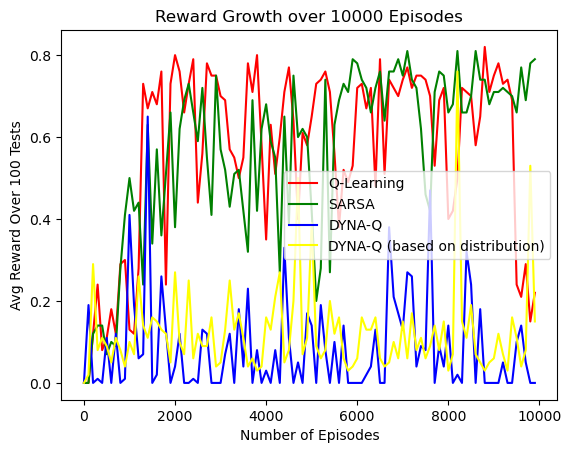

In [100]:
import matplotlib.pyplot as plt
import numpy as np

qLearning = np.loadtxt("target/" + env_name + "-QLearning.csv", delimiter = ",")
SARSA = np.loadtxt("target/" + env_name + "-SARSA.csv", delimiter = ",")
dynaQ = np.loadtxt("target/" + env_name + "-DynaQ.csv", delimiter = ",")
dynaQBasedOnDistribution = np.loadtxt("target/" + env_name + "-DynaQBasedOnDistribution.csv", delimiter = ",")

plt.plot(qLearning[:,0], qLearning[:,1], label = "Q-Learning", color = 'red')
plt.plot(SARSA[:,0], SARSA[:,1], label = "SARSA", color = 'green')
plt.plot(dynaQ[:, 0], dynaQ[:, 1], label = "DYNA-Q", color = 'blue')
plt.plot(dynaQBasedOnDistribution[:, 0], dynaQBasedOnDistribution[:, 1], label = "DYNA-Q (based on distribution)", color = 'yellow')

plt.title("Reward Growth over " + str(numEpisodes) + " Episodes")
plt.xlabel("Number of Episodes")
plt.ylabel("Avg Reward Over 100 Tests")
plt.legend()
plt.show()

In [101]:
# -- QTable
env = gym.make(env_name, render_mode='human') # FrozenLake4x4-v1
test(env, qTable1, 1)
env.close()

average reward = 0.0


In [102]:
# -- SARSA
env = gym.make(env_name, render_mode='human') # FrozenLake4x4-v1
test(env, qTable2, 1)
env.close()

average reward = 1.0


In [103]:
# -- DYNA-Q
env = gym.make(env_name, render_mode='human') # FrozenLake4x4-v1
test(env, qTable3, 1)
env.close()

average reward = 0.0


In [104]:
# -- DYNA-Q (distribution based)
env = gym.make(env_name, render_mode='human') # FrozenLake4x4-v1
test(env, qTable4, 1)
env.close()

average reward = 0.0
